### altimetry data processing 

In [34]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
from shapely import Point
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from utils.functions import sample_from_raster


In [35]:
lake_name = 'hulun'  
path_ht_spavar = f'data/{lake_name}-lake/swot-pixc/raster_height_spavar.nc'
path_lake_vec = f'data/{lake_name}-lake/hydrolake_{lake_name}.gpkg'
paths_atl13 = sorted(glob(f'data/{lake_name}-lake/icesat2/ATL13/*.h5'))
print(len(paths_atl13))


1


In [36]:
# ## chaohu
# path_atl13 = paths_atl13[0] 
# atl13_xr = xr.open_dataset(path_atl13, group='gt2l', engine='h5netcdf') 
# dianchi
# path_atl13 = paths_atl13[0] 
# atl13_xr = xr.open_dataset(path_atl13, group='gt2l', engine='h5netcdf') ## 2l
## gyaring, isat2: 20240113
# path_atl13 = paths_atl13[0] 
# atl13_xr = xr.open_dataset(path_atl13, group='gt1r', engine='h5netcdf') 
## hulun, isat2: 20240721
path_atl13 = paths_atl13[0] 
atl13_xr = xr.open_dataset(path_atl13, group='gt1r', engine='h5netcdf') 
## siling, isat2: 20240728
# path_atl13 = paths_atl13[0] 
# atl13_xr = xr.open_dataset(path_atl13, group='gt3l', engine='h5netcdf') 
atl13_xr


<xarray.Dataset> Size: 174kB
Dimensions:                        (delta_time: 431, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 3kB 2024-07-21...
    segment_lat                    (delta_time) float64 3kB ...
    segment_lon                    (delta_time) float64 3kB ...
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 3kB ...
    bottom_lat                     (delta_time) float64 3kB ...
    bottom_lon                     (delta_time) float64 3kB ...
    cloud_flag_asr_atl09           (delta_time) float32 2kB ...
    cloud_flag_atm_atl09           (delta_time) float32 2kB ...
    cycle_number                   (delta_time) int8 431B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 3kB ...
    stdev_water_surf               (delta_time) float32 2kB ...
    subsurface_attenuation         (delta_time) float32 2kB ...
    subsurface_backscat_ampltd     (delta_time) float32 2kB ...
    transect_id                    (delta_time) float32 2kB ...
    water_depth                    (delta_time) float32 2kB ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     weak
    atlas_pce:           pce1
    atlas_spot_number:   2
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1r
    sc_orientation:      Backward

In [37]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec) 
# ## read geoid correction file
raster_ht_spavar = xr.open_dataset(path_ht_spavar) 


In [38]:
# atl13_xr_b1 = xr.open_dataset(path_atl13, group='gt1l', engine='h5netcdf')
# atl13_xr_b2 = xr.open_dataset(path_atl13, group='gt2l', engine='h5netcdf')
# atl13_xr_b3 = xr.open_dataset(path_atl13, group='gt3l', engine='h5netcdf')
# atl13_xr = xr.concat([atl13_xr_b1, atl13_xr_b2, atl13_xr_b3], dim='delta_time')
# atl13_xr


#### 1. show the icesat-2 track on the swot variation raster.

In [39]:
## create a interior buffered lake vector
lake_decrease_gdf = lake_gdf.copy()
lon_center = lake_decrease_gdf.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=epsg_code)
lake_decrease_gdf['geometry'] = lake_decrease_gdf.geometry.buffer(-1000)
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=4326)
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(atl13_xr['segment_lon'].values, atl13_xr['segment_lat'].values)]
ids_valid_atl13 = np.where(lake_decrease_gdf.geometry[0].contains(points))[0]
atl13_xr_mask = atl13_xr.isel({'delta_time': ids_valid_atl13})
atl13_xr_mask


<xarray.Dataset> Size: 162kB
Dimensions:                        (delta_time: 401, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 3kB 2024-07-21...
    segment_lat                    (delta_time) float64 3kB 48.92 ... 49.28
    segment_lon                    (delta_time) float64 3kB 117.6 ... 117.5
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 3kB ...
    bottom_lat                     (delta_time) float64 3kB ...
    bottom_lon                     (delta_time) float64 3kB ...
    cloud_flag_asr_atl09           (delta_time) float32 2kB ...
    cloud_flag_atm_atl09           (delta_time) float32 2kB ...
    cycle_number                   (delta_time) int8 401B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 3kB ...
    stdev_water_surf               (delta_time) float32 2kB ...
    subsurface_attenuation         (delta_time) float32 2kB ...
    subsurface_backscat_ampltd     (delta_time) float32 2kB ...
    transect_id                    (delta_time) float32 2kB ...
    water_depth                    (delta_time) float32 2kB ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     weak
    atlas_pce:           pce1
    atlas_spot_number:   2
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1r
    sc_orientation:      Backward

Text(0.5, 1.0, 'Corrected Geoid')

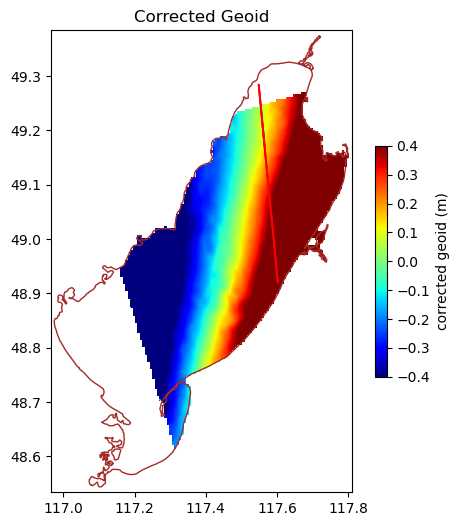

In [40]:
extent_raster = [raster_ht_spavar.x.min(), raster_ht_spavar.x.max(),
           raster_ht_spavar.y.min(), raster_ht_spavar.y.max()]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
## plot the smoothed spatial variation of lake surface height
img_show1 = ax.imshow(raster_ht_spavar.ht_spavar_smoothed.values, cmap='jet', 
                        vmin = -0.4, vmax = 0.4, extent=extent_raster)
lake_gdf.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax.scatter(x=atl13_xr_mask.segment_lon, y=atl13_xr_mask.segment_lat, 
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax, label='corrected geoid (m)', shrink=0.5)
ax.set_title('Corrected Geoid')


In [41]:
## Sample corrected geoid values at ATL13 points
atl13_track_spavar = sample_from_raster(
        raster_value=raster_ht_spavar.ht_spavar_smoothed.values,
        raster_x = raster_ht_spavar.x.values,
        raster_y = raster_ht_spavar.y.values,
        points_x = atl13_xr_mask.segment_lon.values,
        points_y = atl13_xr_mask.segment_lat.values
        )
atl13_median = np.nanmedian(atl13_xr_mask.ht_water_surf.values) 
atl13_spavar = atl13_xr_mask.ht_water_surf.values - atl13_median


#### 2. Correlation bettween icesat-2 and swot height variation

In [42]:
ids_mask = np.isfinite(atl13_track_spavar) & np.isfinite(atl13_spavar)
data_spavar = pd.DataFrame({'ht_var_swot': atl13_track_spavar[ids_mask],
                            'ht_var_atl13': atl13_spavar[ids_mask]}) 
slope, intercept, r_value, p_value, std_err = stats.linregress(data_spavar['ht_var_swot'], 
                                                               data_spavar['ht_var_atl13'])


Text(0.5, 1.0, 'hulun Lake')

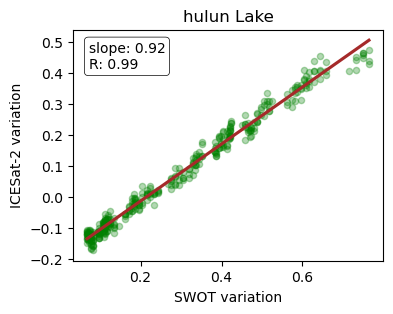

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.regplot(data=data_spavar, 
            x="ht_var_swot", 
            y="ht_var_atl13", 
            ci=None,
            line_kws={"color": "brown"}, marker='o', 
            scatter_kws={"s": 20, "alpha":0.3, "color":"green"}, ax=ax)
plt.annotate(f'slope: {slope:.2f}\nR: {r_value:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=0.5))
ax.set_xlabel('SWOT variation')
ax.set_ylabel('ICESat-2 variation')
ax.set_title(f'{lake_name} Lake')
# ax.set_ylim(-0.16, 0.16)
# ax.set_xlim(-0.05, 0.16)


### 3. apply the corrected geoid for lake level retrieval

In [44]:
atl13_track_spavar_ = atl13_track_spavar - np.nanmedian(atl13_track_spavar)  ## zero-centered  
atl13_ht_ortho = atl13_xr_mask.ht_water_surf.values - atl13_xr_mask.segment_geoid.values  ## equal to atl13_xr.ht_ortho
atl13_geoid_cor = atl13_xr_mask.segment_geoid.median().values + atl13_track_spavar_
atl13_ht_ortho_cor = atl13_xr_mask.ht_water_surf.values - atl13_geoid_cor


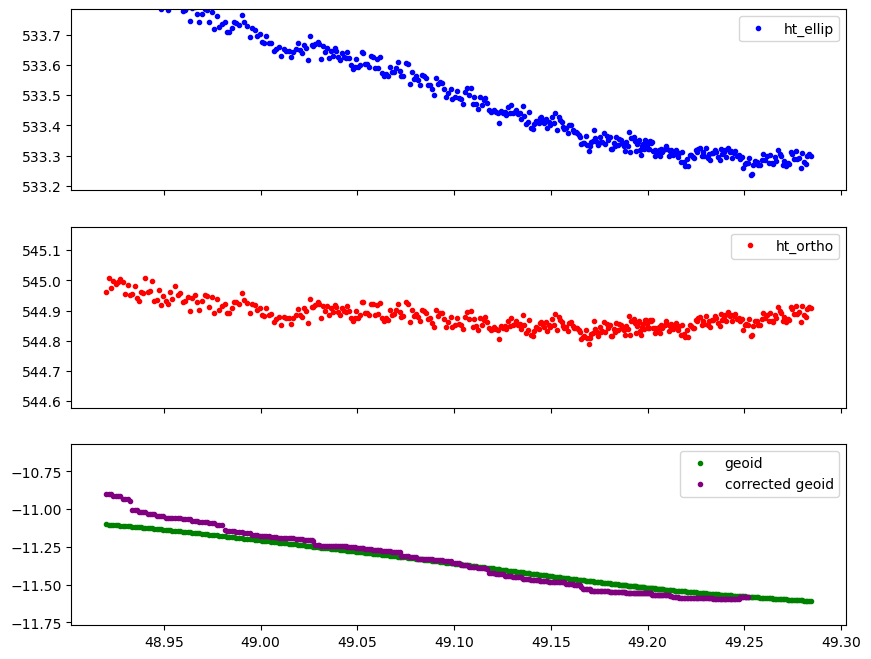

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
## plot height_ellip
ht_mean = np.mean(atl13_xr_mask.ht_water_surf.values)
ax[0].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.ht_water_surf.values, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_ellip')
ax[0].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[0].legend()
## plot height_ortho
ht_ortho_mean = np.nanmean(atl13_xr_mask.ht_ortho.values)
ax[1].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.ht_ortho.values, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_ortho_mean - 0.3, ht_ortho_mean + 0.3)
ax[1].legend()
## plot geoid
atl13_geoid_mean = np.nanmean(atl13_xr_mask.segment_geoid.values)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.segment_geoid.values, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='geoid')
ax[2].set_ylim(atl13_geoid_mean - 0.3, atl13_geoid_mean + 0.3)

atl13_geoid_cor_mean = np.nanmean(atl13_geoid_cor)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='corrected geoid')
ax[2].set_ylim(atl13_geoid_cor_mean - 0.4, atl13_geoid_cor_mean + 0.8)
ax[2].legend()


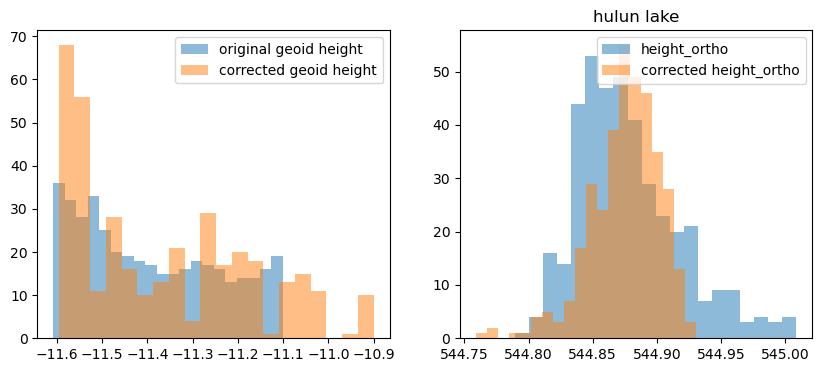

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(atl13_xr_mask.segment_geoid.values.ravel(), bins=20, alpha=0.5, label='original geoid height');
ax[0].hist(atl13_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid height');
ax[0].legend();
ax[1].hist(atl13_ht_ortho, bins=20, alpha=0.5, label='height_ortho');
ax[1].hist(atl13_ht_ortho_cor, bins=20, alpha=0.5, label='corrected height_ortho');
ax[1].legend();
ax[1].set_title(f'{lake_name} lake');


In [47]:
atl13_ht_ds = xr.Dataset({
  "geoid": (["delta_time"], atl13_xr_mask.segment_geoid.values),
  "geoid_cor": (["delta_time"], atl13_geoid_cor),  
  "ht_ellip": (["delta_time"], atl13_xr_mask.ht_water_surf.values),
  "ht_ortho": (["delta_time"], atl13_ht_ortho),
  "ht_ortho_cor": (["delta_time"], atl13_ht_ortho_cor)
}, coords={
  "delta_time": atl13_xr_mask["delta_time"],
  "segment_lon": atl13_xr_mask["segment_lon"],
  "segment_lat": atl13_xr_mask["segment_lat"]
})

path_save = path_atl13.replace('.h5', '_height.nc')
# atl13_ht_ds.to_netcdf(path_save)
atl13_ht_ds


<xarray.Dataset> Size: 21kB
Dimensions:       (delta_time: 401)
Coordinates:
  * delta_time    (delta_time) datetime64[ns] 3kB 2024-07-21T02:57:50.5024462...
    segment_lat   (delta_time) float64 3kB 48.92 48.92 48.92 ... 49.28 49.28
    segment_lon   (delta_time) float64 3kB 117.6 117.6 117.6 ... 117.5 117.5
Data variables:
    geoid         (delta_time) float32 2kB -11.1 -11.1 -11.1 ... -11.61 -11.61
    geoid_cor     (delta_time) float64 3kB -10.9 -10.9 -10.9 ... nan nan nan
    ht_ellip      (delta_time) float32 2kB 533.9 533.9 533.9 ... 533.3 533.3
    ht_ortho      (delta_time) float32 2kB 545.0 545.0 545.0 ... 544.9 544.9
    ht_ortho_cor  (delta_time) float64 3kB 544.8 544.8 544.8 ... nan nan nan

In [48]:
print('std of ellip height:          ', np.nanstd(atl13_ht_ds['ht_ellip']))
print('std of geoid height:          ', np.nanstd(atl13_ht_ds['ht_ortho']))
print('std of geoid height corrected:', np.nanstd(atl13_ht_ds['ht_ortho_cor']))


std of ellip height:           0.18286881
std of geoid height:           0.040443733
std of geoid height corrected: 0.026788861003419356


In [49]:
x = np.linspace(atl13_xr_mask.segment_lat.min(), atl13_xr_mask.segment_lat.max(), 100)
ht_ellip_median = np.nanmedian(atl13_ht_ds['ht_ellip'])
ht_ortho_median = np.nanmedian(atl13_ht_ds['ht_ortho'])
ht_ortho_cor_median = np.nanmedian(atl13_ht_ds['ht_ortho_cor'])
ht_ellip_df = pd.DataFrame({'segment_lat': atl13_xr_mask.segment_lat,
                             'ht_ellip': atl13_ht_ds['ht_ellip'] - ht_ellip_median})
ht_ortho_df = pd.DataFrame({'segment_lat': atl13_xr_mask.segment_lat,
                             'ht_ortho': atl13_ht_ds['ht_ortho'] - ht_ortho_median})
ht_ortho_cor_df = pd.DataFrame({'segment_lat': atl13_xr_mask.segment_lat,
                             'ht_ortho_cor': atl13_ht_ds['ht_ortho_cor'] - ht_ortho_cor_median})


<Axes: xlabel='segment_lat', ylabel='ht_ortho_cor'>

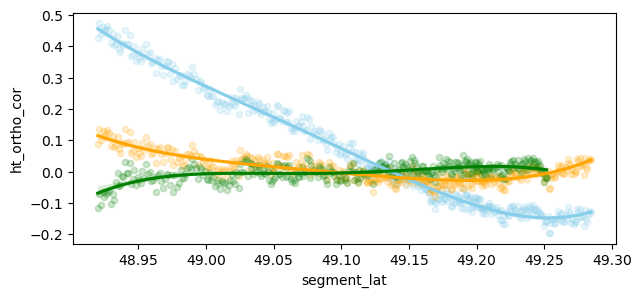

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
sns.regplot(data=ht_ellip_df, x="segment_lat", y="ht_ellip", order=4, ax=ax, line_kws={"color": "skyblue"}, marker='o', scatter_kws={"s": 20, "alpha":0.2, "color":"skyblue"})
sns.regplot(data=ht_ortho_df, x="segment_lat", y="ht_ortho", order=4, ax=ax, line_kws={"color": "orange"}, marker='o', scatter_kws={"s": 20, "alpha":0.2, "color":"orange"})
sns.regplot(data=ht_ortho_cor_df, x="segment_lat", y="ht_ortho_cor", order=4, ax=ax, line_kws={"color": "green"}, marker='o', scatter_kws={"s": 20, "alpha":0.2, "color":"green"})

